In [1]:
from utils import download_dataset_if_needed

from models.knn_model import KnnModel

import pandas as pd
import numpy as np

import os

from datasets.dataset import Dataset
from datasets import livingroom
from datasets.roomsetup import RoomSetup
import matplotlib.pyplot as plt

import librosa

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from utils import download_dataset_if_needed, get_dataset
from feature_extraction.rms import generate_rms, normalize_rms, reshape_rms

In [2]:
download_dataset_if_needed()

path: ./LivingRoom_preprocessed_hack already exist, ignorign dataset downloading


In [3]:
DATASET_PATH = "LivingRoom_preprocessed_hack"
empty_dataset = get_dataset(None, "deconvolved.npy", os.path.join(DATASET_PATH, "Empty"))
human1_dataset = get_dataset("centroid.npy", "deconvoled_trim.npy", os.path.join(DATASET_PATH, "Human1"))

Shape of RIRs:
(100, 10, 667200)
Shape of Centroid:
(1000, 2)
Shape of RIRs:
(1000, 4, 667200)


In [4]:
# human_rms = generate_rms(human1_dataset)
human_rms = generate_rms(human1_dataset, frame_length=2048, hop_length=512)

Load precomputed rms


In [5]:
knn = KnnModel(n_neighbors=3)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(human_rms, human1_dataset[1], test_size=0.2, random_state=42)

In [7]:
y_train

array([[-2366.53094805, -2087.42202519],
       [-1757.74346697,  1114.06245508],
       [-2101.841677  ,  -370.06180814],
       ...,
       [ -589.25358263, -3373.45859729],
       [-2312.29348817, -1079.74662326],
       [-2413.13954179,   719.13003332]])

In [8]:
# Train the KNN model
knn.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn.predict(X_test)

In [9]:
knn.model.score(X_test, y_test)

0.8252809069419917

In [10]:
dist = np.linalg.norm(y_pred - y_test,axis=1)

In [11]:
avg = np.average(dist)
std = np.std(dist)
print(avg,std)

528.2846521030868 512.5733589400173


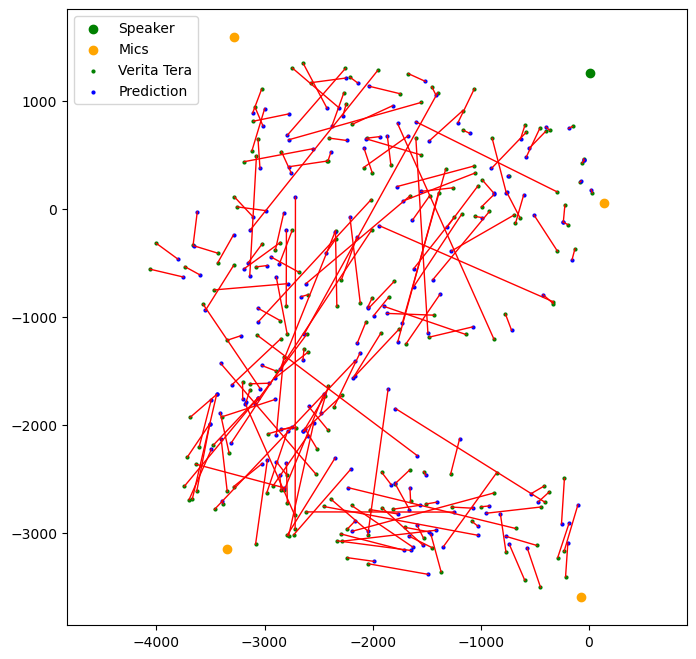

In [12]:
human1_dataset[0].room_setup.plot_prediction(y_pred, y_test)